# 20165172 빅데이터 박한솔 기말 Project 자유주제

**기말 Project2 : Wine-Quality and scikit_learn** <br>
Wine Quality 데이터 학습, 평가(교차검증) <br>
1) 목적 : Wine Quality데이터를 가지고 (SVM / DecisionTree / RandomForest) 분류기를 이용하여 와인의 퀄리티를 예측, 학습, 평가한다 <br>
2) 내용 및 방법 : 데이터 읽기 및 분석, 모델 성능평가<br>
3) 결과 : 성능 비교 후 우수 분류기 파라미터 튜닝 및 결과 분석<br>
* 성능 비교표
* 파라미터 튜닝
* ROC Curve
* Classification Report
* cut-off
* Importance

#설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#데이터 읽기 및 분석

In [2]:
import pandas as pd

In [6]:
DF = pd.read_csv("winequality-red.csv") # 전체 테이블을 위한

In [7]:
WQ = pd.read_csv("winequality-red.csv")
WQ

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
#결측치 확인
WQ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


* Input variables (based on physicochemical tests):<br>
1 - fixed acidity (고정 산도) <br>
2 - volatile acidity (휘발성 산도)<br>
3 - citric acid (구연산)<br>
4 - residual sugar (잔류 설탕)<br>
5 - chlorides (염화물)<br>
6 - free sulfur dioxide (유리 이산화황)<br>
7 - total sulfur dioxide (총 이산화황)<br>
8 - density (밀도)<br>
9 - pH<br>
10 - sulphates (황산염)<br>
11 - alcohol (알코올)<br>
<br>
* Output variable (based on sensory data):<br>
12 - quality (score between 0 and 10)

상관관계 확인

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

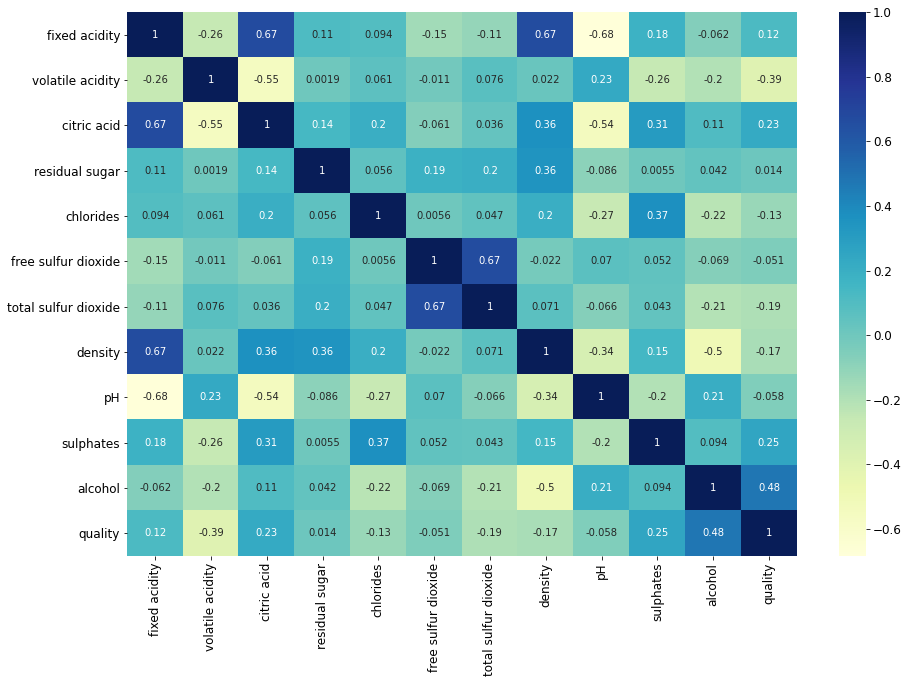

In [ ]:
corr = WQ.corr()
plt.subplots (figsize= (15,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels= corr.columns, annot = True, cmap='YlGnBu')

In [8]:
y = WQ.pop('quality')
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

kaggle 데이터에서 권장한 y>=7 경우 1로 이진 분류 설정

In [9]:
y = np.asarray([1 if i>=7 else 0 for i in y])

In [10]:
X = WQ
WQ

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [ ]:
type(X), type(y)

(pandas.core.frame.DataFrame, numpy.ndarray)

X를 numpy 배열로 변환

In [11]:
X = X.values
type(X)

numpy.ndarray

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [14]:
X_train.shape , X_test.shape

((1119, 11), (480, 11))

#1) 모델 성능 평가 (Default)

##SVM

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [16]:
svc_clf = SVC(random_state=42)
svc_clf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [17]:
svc_train_cv_score = cross_val_score(svc_clf, X_train, y_train, cv=10, scoring="accuracy")
svc_train_score = np.average(svc_train_cv_score) # train
svc_train_score

0.8659507722007722

In [20]:
y_pred = svc_clf.predict(X_test)
svc_test_score = accuracy_score(y_test, y_pred)
svc_test_score

0.8625

##DecisionTree

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
dtc_clf = DecisionTreeClassifier(random_state=42) 
dtc_clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
dt_train_cvs = cross_val_score(dtc_clf, X_train, y_train, cv=10, scoring="accuracy")
dt_train_score = np.average(dt_train_cvs)
dt_train_score

0.8784990347490348

In [23]:
y_pred = dtc_clf.predict(X_test)
dtc_test_score = accuracy_score(y_test, y_pred)
dtc_test_score

0.8604166666666667

##RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rfc_clf = RandomForestClassifier(random_state=42)
rfc_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rfc_train_cvs = cross_val_score(rfc_clf, X_train, y_train, cv=10, scoring="accuracy")
rfc_train_score = np.average(rfc_train_cvs) # accuracy average
rfc_train_score

0.9115588803088803

In [26]:
y_pred = rfc_clf.predict(X_test)
rfc_test_score = accuracy_score(y_test, y_pred)
rfc_test_score

0.89375

##SVM, DecisionTree, RandomForest 정확도 비교

In [28]:
import pandas as pd
pd.DataFrame(data = [svc_test_score, dtc_test_score, rfc_test_score], index=["SVC","DecisionTree","RandomForest"], columns=["Accuracy"])

,Accuracy
SVC,0.862500
DecisionTree,0.860417
RandomForest,0.893750


#2) 가장 좋은 분류기 성능 계산

RandomForest 평가

##파라미터 튜닝

n_estimators (트리 수) 탐색

In [44]:
best_score = 0
box_score = [] #박스플로에 사용될 array

for estimators in range(1,40):
  rfc_clf = RandomForestClassifier(n_estimators=estimators, random_state=42)
  scores = cross_val_score(rfc_clf, X_train,y_train, cv=10)
  box_score.append(scores)
  score = np.mean(scores)
  
  if score > best_score:
    best_score = score
    best_estimators = estimators

In [45]:
best_score, best_estimators

(0.9124436936936936, 25)

Best n_estimators : 25

In [46]:
rfc_clf =  RandomForestClassifier(n_estimators=best_estimators, random_state=42)
rfc_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [47]:
scores = cross_val_score(rfc_clf, X_train,y_train, cv=10)
score = np.mean(scores)
score

0.9124436936936936

In [49]:
y_pred = rfc_clf.predict(X_test)
rfc_test_score = accuracy_score(y_test, y_pred)
rfc_test_score

8975833333333333

Boxplot으로 분포 확인

In [ ]:
from matplotlib import pyplot as plt

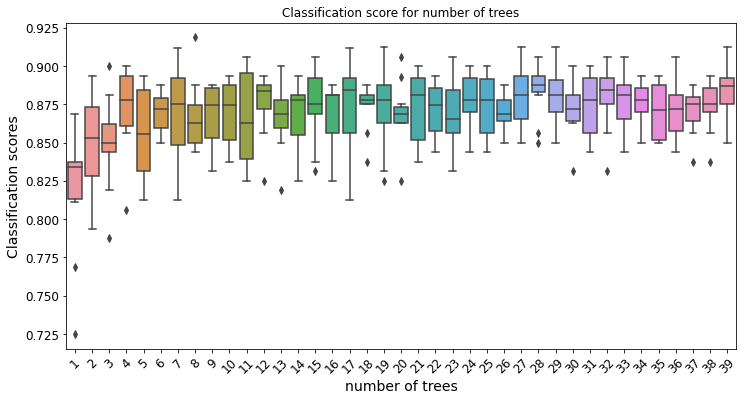

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=box_score)
plt.xlabel('number of trees')
plt.ylabel('Classification scores')
plt.title('Classification score for number of trees')
plt.xticks(range(0,39), labels=range(1,40), rotation=45) # X 인덱스 1부터 시작
plt.show()

tree의 수가 많을 수록 scores가 높다는 것을 확인

##ROC Curve

In [ ]:
y_pred = rfc_clf.predict_proba(X_test)[:,1]

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
from sklearn.metrics import auc

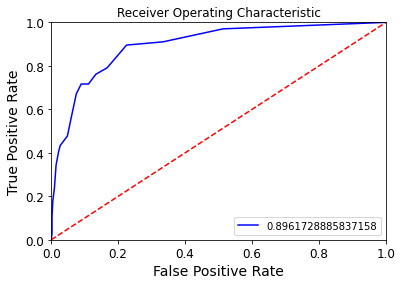

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test , y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label =  roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Classification Report

민감도와 특이도 모두 좋은 수치를 보이고 있다.

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, rfc_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       413
           1       0.65      0.45      0.53        67

    accuracy                           0.89       480
   macro avg       0.78      0.70      0.73       480
weighted avg       0.88      0.89      0.88       480



## cut-off

F1 = (2 X recall X precision) / (recall+preicision) <br>
정밀도와 재현율이 모두 강한 분류기를 선호 F1_score <br>
* 예측 확률을 예측으로 변환 할 때 가장 좋은 F1 Score를 위한 cut-off 탐색

In [ ]:
def cutoff_predict(rfc_clf, X, cutoff):
  return (rfc_clf.predict_proba(X)[:,1]> cutoff).astype(int)

box_score=[]

def custom_f1(cutoff):
  def f1_cutoff(rfc_clf, X, y):
    ypred = cutoff_predict(rfc_clf,X,cutoff)
    return sklearn.metrics.f1_score(y,ypred)
  
  return f1_cutoff

for cutoff in np.arange(0.1, 0.9, 0.1):
  rfc_clf = RandomForestClassifier(n_estimators=18)
  val = cross_val_score(rfc_clf, X, y, cv=10, scoring= custom_f1(cutoff))
  box_score.append(val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


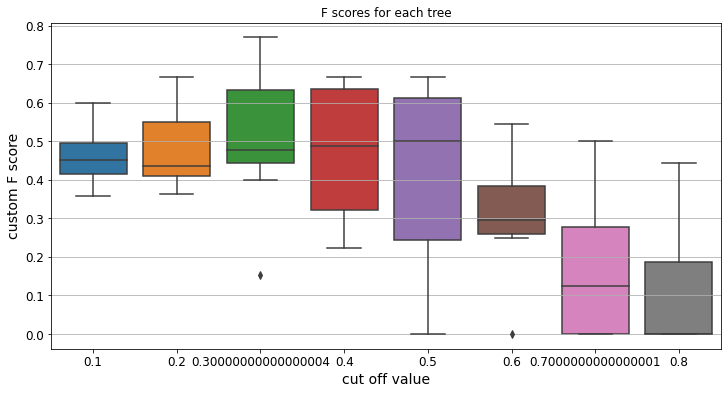

In [ ]:
import matplotlib.ticker as mtick
plt.figure(figsize=(12,6))
sns.boxplot(data=box_score)
plt.title('F scores for each tree')
plt.xlabel('cut off value')
plt.ylabel('custom F score')
ax = plt.axes()
ax.yaxis.grid()
plt.xticks(np.arange(0,8,1), labels=(np.arange(0.1, 0.9, 0.1)))
plt.show()

0.3 ~ 0.5 cutoff 에서 높은 예측을 보여줌

보통 y>0.5 로 판단함 <br>
최적의 cut-off 탐색

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = rfc_clf.predict_proba(X_test)[:,1]
y_pred_3 = (y_pred > 0.3).astype(int)
accuracy_score(y_test , y_pred_3)

0.8645833333333334

In [ ]:
y_pred = rfc_clf.predict_proba(X_test)[:,1]
y_pred_5 = (y_pred > 0.5).astype(int)
accuracy_score(y_test , y_pred_5)

0.8854166666666666

In [ ]:
#비교
y_pred = rfc_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8854166666666666

##Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [ ]:
y_test_pred = cross_val_predict(rfc_clf, X_test, y_test, cv=10)
conf_mx = confusion_matrix(y_test,y_test_pred)
conf_mx

array([[403,  10],
       [ 49,  18]])

## importance

In [ ]:
imp = rfc_clf.feature_importances_

([<matplotlib.axis.YTick at 0x7fcd990b37f0>,
 [Text(0, 0, 'fixed acidity'),
  Text(0, 0, 'volatile acidity'),
  Text(0, 0, 'citric acid'),
  Text(0, 0, 'residual sugar'),
  Text(0, 0, 'chlorides'),
  Text(0, 0, 'free sulfur dioxide'),
  Text(0, 0, 'total sulfur dioxide'),
  Text(0, 0, 'density'),
  Text(0, 0, 'pH'),
  Text(0, 0, 'sulphates'),
  Text(0, 0, 'alcohol')])

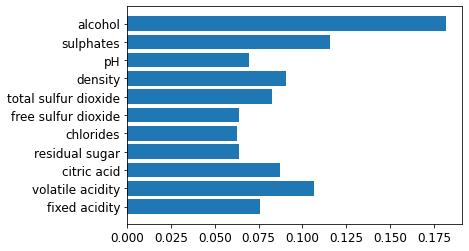

In [ ]:
import matplotlib.pyplot as plt

plt.barh(range(len(WQ.columns)), imp, align='center') # y에 얼마나 영향을 미치는지
plt.yticks(range(len(WQ.columns)), WQ.columns) # 축이름

alcohol, sulphates, volatile acidity, density ... 순으로 영향을 크게 미침

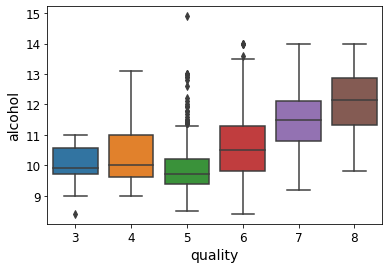

In [ ]:
al = sns.boxplot(x='quality', y='alcohol', data=DF)

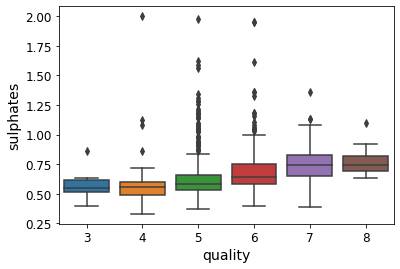

In [ ]:
su = sns.boxplot(x='quality', y='sulphates', data=DF)

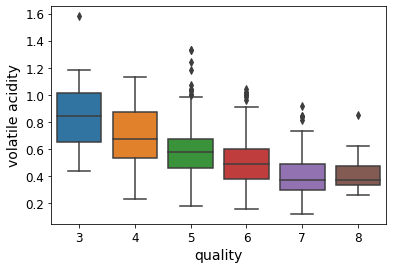

In [ ]:
vo = sns.boxplot(x='quality', y='volatile acidity', data=DF)

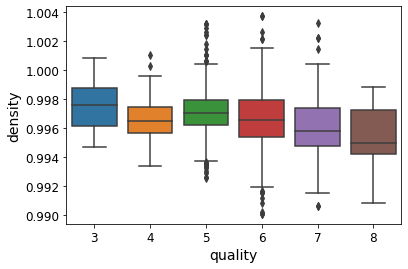

In [ ]:
de = sns.boxplot(x='quality', y='density', data=DF)